In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Define random state
np.random.seed(123)
rs = 123

In [2]:
# Import fullly preprocessed dataset
filepath = "../data_processing/processed_merged_data/full_dataset.csv"
df = pd.read_csv(filepath)

In [3]:
# Log transform GVA_Real_Density and Tax_D_Real
df['GVA_Real_Density'] = np.log(df['GVA_Real_Density'])
df['Tax_D_Real'] = np.log(df['Tax_D_Real'])

In [4]:
# Remove alternate outcome "GVA_Real"
ml_df = df.drop(columns=['GVA_Real'])

# Remove all cols with GDHI in the name (mediators)
ml_df = ml_df.loc[:, ~ml_df.columns.str.contains('GDHI')]

# Remove non time-varying variables
ml_df = ml_df.drop(columns=['Area', 'Region', 'Authority_Type'])

# Create fixed effects through one-hot encoding
ml_df = pd.get_dummies(ml_df, columns=['LACD'])

# Remove id columns
ml_df = ml_df.drop(columns=['LANM'])

# Show cols and number of cols
print(ml_df.columns)
print(f"Number of Columns: {len(ml_df.columns)}")

Index(['Year', 'Claimants_Total', 'Claimants_Density_16_64',
       'Claimants_16_64_Prop', 'Jobs_Total', 'Jobs_Density_16_64', 'Age_Avg',
       'Pop_Total', 'Pop_Male', 'Pop_Female',
       ...
       'LACD_E09000024', 'LACD_E09000025', 'LACD_E09000026', 'LACD_E09000027',
       'LACD_E09000028', 'LACD_E09000029', 'LACD_E09000030', 'LACD_E09000031',
       'LACD_E09000032', 'LACD_E09000033'],
      dtype='object', length=347)
Number of Columns: 347


## Treatment Prediction Model

In [5]:
# Define model X and y
model_outcome = 'Tax_D_Real'
corresp_var = 'GVA_Real_Density'

X = ml_df.drop(columns=[model_outcome] + [corresp_var])
y = ml_df[model_outcome]

# Manually define set of row indices consistent across both models
test_indices = np.random.choice(X.index,
                                size=int(0.2 * len(X)),
                                replace=False)
train_indices = np.setdiff1d(X.index, test_indices)

# Use these indices to split the data
X_train, X_test = X.loc[train_indices], X.loc[test_indices]
y_train, y_test = y.loc[train_indices], y.loc[test_indices]

# Define the parameter grid
param_grid = {
    'n_estimators': [300, 400, 600, 800],
    'max_features': ['sqrt', 0.25, 0.1],
    'max_depth': [ None, 30, 40, 50],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 5]
}

In [6]:
# Perform Randomised Search
rf = RandomForestRegressor(random_state=rs)
random_search = RandomizedSearchCV(estimator=rf,
                                   param_distributions=param_grid, 
                                   n_iter=100,
                                   cv=5,
                                   verbose=2,
                                   random_state=rs,
                                   n_jobs=-1)
random_search.fit(X_train, y_train)

# Print best parameters
print("Best parameters:", random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   5.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   5.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   5.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   5.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   5.2s
[CV] END max_depth=40, max_features=0.1, min_samples_leaf=2, min_samples_split=8, n_estimators=300; total time=   5.6s
[CV] END max_depth=40, max_features=0.1, min_samples_leaf=2, min_samples_split=8, n_estimators=300; total time=   5.8s
[CV] END max_depth=40, max_features=0.1, min_samples_leaf=2, min_samples_split=8, n_estim

In [13]:
# Predict on test set
y_hat = random_search.predict(X_test)

# Model perfomance metrics
mse = mean_squared_error(y_test, y_hat)
print("Mean Squared Error:", mse)

mae = mean_absolute_error(y_test, y_hat)
print("Mean Absolute Error:", mae)

y_test_mean = np.mean(y_test)
print("Average y_test:", y_test_mean)
y_test_var = np.var(y_test)
print("Variance of y_test:", y_test_var)

r2 = r2_score(y_test, y_hat)
print("R^2 score:", r2)

Mean Squared Error: 0.0016611924976863994
Mean Absolute Error: 0.03080639978019323
Average y_test: 7.438577504002477
Variance of y_test: 0.01917386548334821
R^2 score: 0.9133616276212492


In [109]:
# Define plot function
def plot_true_vs_fitted(true, fitted, filename=None):

    plt.rcParams['font.family'] = 'Times New Roman'

    # Plotting
    plt.figure(figsize=(8, 8))
    plt.scatter(true, fitted, color='steelblue', alpha=0.6, zorder=2)
    plt.plot([min(true), max(true)],
             [min(true), max(true)],
             color='black', linestyle='--', linewidth=2, zorder=3)

    # Customising axis labels with larger font sizes
    plt.xlabel("True Values (Log-Scale)", fontsize=20)
    plt.ylabel("Fitted Values (Log-Scale)", fontsize=20)

    # Customising the grid and axis appearance
    plt.grid(True, axis='both', color='lightgrey',
             linestyle='-', linewidth=0.5, zorder=1)
    plt.axis('equal')

    # Resetting ticks to default
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    # Remove border
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    # Save the plot if filename is provided
    if filename:
        plt.savefig(filename, bbox_inches='tight', dpi=300)

    # Show the plot
    plt.show()

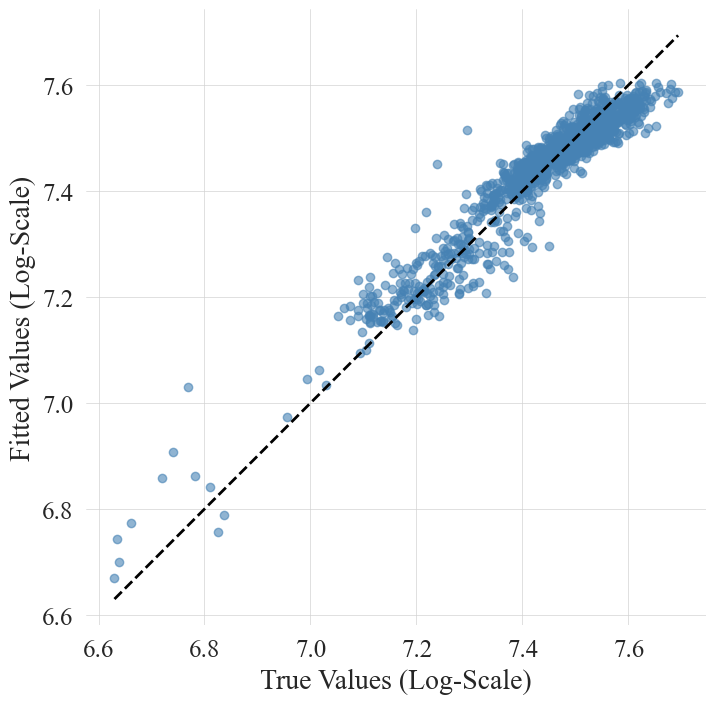

In [114]:
# Plot true vs fitted
plot_true_vs_fitted(y_test, y_hat, filename="./figures/dmodel_scatter.png")

                        Importance
Year                      0.342325
Pop_Aged_25_49_Prop       0.083122
Pop_Density               0.040869
Jobs_Density_16_64        0.035444
Hs_Sales_Total_Density    0.035220
...                            ...
LACD_E07000077            0.000002
LACD_E07000144            0.000002
LACD_E07000046            0.000002
LACD_E07000166            0.000002
LACD_E07000163            0.000002

[345 rows x 1 columns]


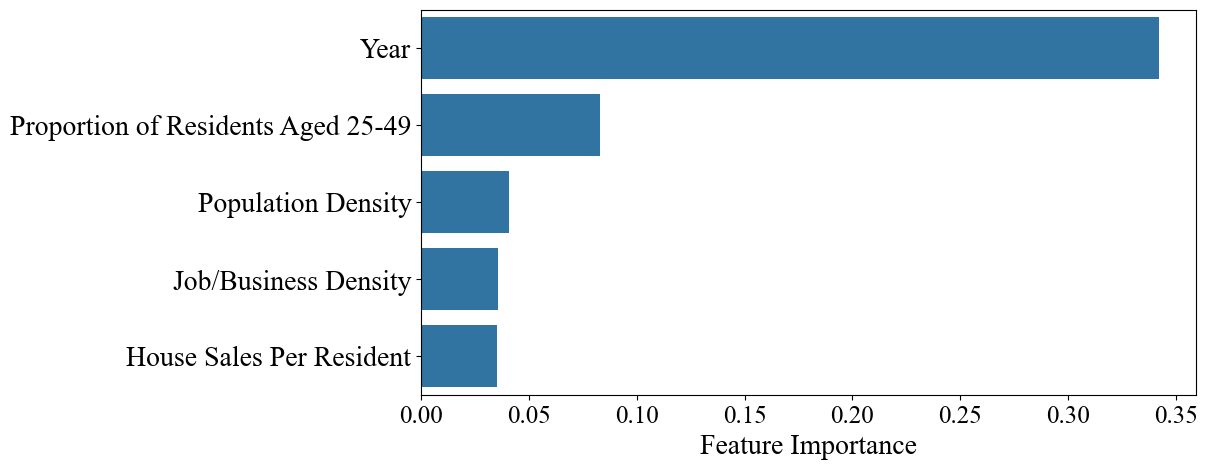

In [65]:
# Extract feature importance
feature_importances = random_search.best_estimator_.feature_importances_
feature_importances_df = pd.DataFrame(feature_importances,
                                      index=X.columns,
                                      columns=['Importance'])

feature_importances_df = feature_importances_df.sort_values(
    by='Importance',
    ascending=False)

# Display feature importance output
print(feature_importances_df)

# Set the font size for the entire plot
plt.rcParams.update({
    'axes.labelsize': 20,
    'xtick.labelsize': 18,
    'ytick.labelsize': 20,
})

# Custom variable names
custom_labels = {
    'Year': 'Year',
    'Pop_Aged_25_49_Prop': 'Proportion of Residents Aged 25-49',
    'Pop_Density': 'Population Density',
    'Jobs_Density_16_64': 'Job/Business Density',
    'Hs_Sales_Total_Density': 'House Sales Per Resident'
}

# Extract the top 5 features
top_features = feature_importances_df['Importance'][:5]
feature_names = feature_importances_df.index[:5]

# Rename the features according to the custom labels
renamed_feature_names = [custom_labels.get(name, name)
                          for name in feature_names]

# Plotting
plt.figure(figsize=(10, 5))
sns.barplot(x=top_features, y=renamed_feature_names)
plt.xlabel('Feature Importance')

# Save the plot
plt.savefig('./figures/dmodel_features.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [67]:
def visualise_gps(varname, variable, gps):
    # Create df with the true variable and GPS
    gps_df = pd.DataFrame({'var_true': variable, 'gps': gps})
    
    # Divide the true variable into quartiles
    gps_df['var_bins'] = pd.qcut(gps_df['var_true'], q=4,
                                 labels=['1', '2', '3', '4'])
    
    # Sort the DataFrame by bin labels to ensure correct order
    gps_df = gps_df.sort_values(by='var_bins')
    
    # Set font
    plt.rcParams['font.family'] = 'Times New Roman'
    
    # Create density plots
    plt.figure(figsize=(12, 8))
    for label in gps_df['var_bins'].unique():
        sns.kdeplot(gps_df[gps_df['var_bins'] == label]['gps'], label=f'{varname} Quartile {label}', fill=True)
    
    # Define aesthetics
    plt.xlabel('Generalized Propensity Score (GPS)', fontsize=22)
    plt.ylabel('Density', fontsize=22)
    plt.legend(loc='upper left', fontsize=18, title_fontsize=20, frameon=True)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    # Save plot
    plt.savefig(f'./figures/gps_density.png', dpi=300, bbox_inches='tight')

    # Show plot
    plt.show()

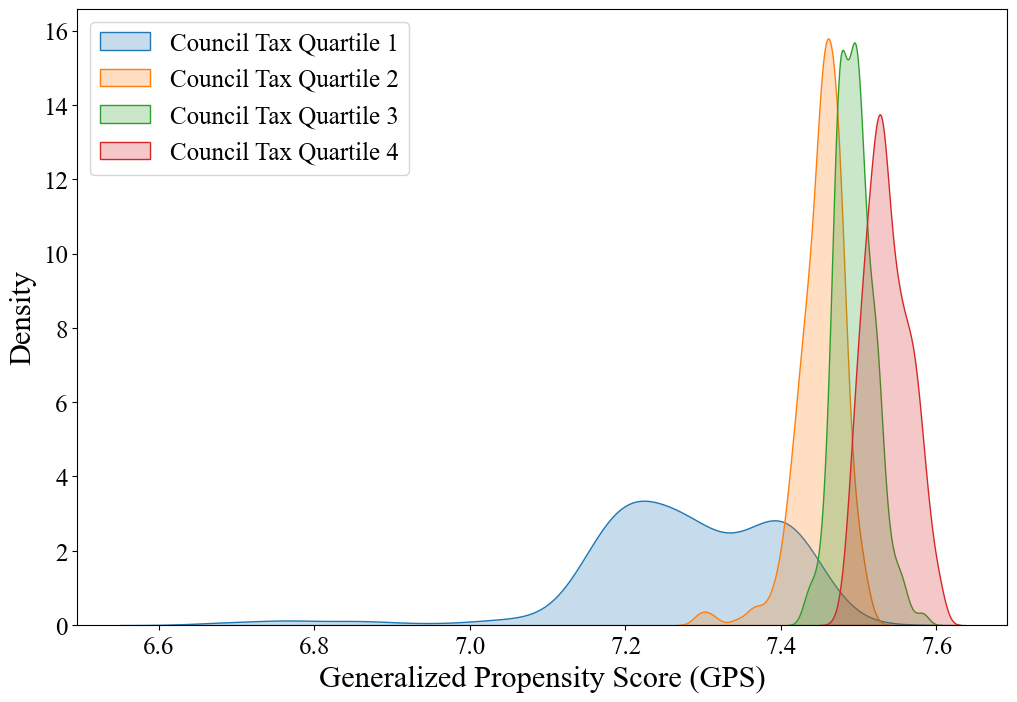

In [68]:
# Visualise GPS
visualise_gps('Council Tax', y_test, y_hat)

## Outcome Prediction Model

In [18]:
# Define model X1 and y1
model_outcome1 = "GVA_Real_Density"
corresp_var1 = "Tax_D_Real"

X1 = ml_df.drop(columns=[model_outcome1] + [corresp_var1])
y1 = ml_df[model_outcome1]

# Use the same indices to split the data as before
X_train1, X_test1 = X1.loc[train_indices], X1.loc[test_indices]
y_train1, y_test1 = y1.loc[train_indices], y1.loc[test_indices]

# Define the parameter grid
param_grid1 = {
    'n_estimators': [100, 200, 400, 600, 800],
    'max_features': ['sqrt', 0.25, 0.1],
    'max_depth': [ None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 4, 8, 10],
    'min_samples_leaf': [1, 2, 5, 10]
}

In [19]:
# Perform randomised search
rf = RandomForestRegressor(random_state=rs)
random_search1 = RandomizedSearchCV(estimator=rf,
                                   param_distributions=param_grid1, 
                                   n_iter=100,
                                   cv=5,
                                   verbose=2,
                                   random_state=rs,
                                   n_jobs=-1)
random_search1.fit(X_train1, y_train1)

# Print best parameters
print("Best parameters:", random_search1.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END max_depth=30, max_features=0.1, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=  10.3s
[CV] END max_depth=30, max_features=0.1, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=  10.5s
[CV] END max_depth=30, max_features=0.1, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=  10.5s
[CV] END max_depth=30, max_features=0.1, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=  10.5s
[CV] END max_depth=30, max_features=0.1, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=  10.6s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=200; total time=   1.7s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=200; total time=   1.7s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=2

In [20]:
# Predict on test set
y_hat1 = random_search1.predict(X_test1)

# Model perfomance metrics
mse = mean_squared_error(y_test1, y_hat1)
print("Mean Squared Error:", mse)

mae = mean_absolute_error(y_test1, y_hat1)
print("Mean Absolute Error:", mae)

y_test_mean = np.mean(y_test1)
print("Average y_test:", y_test_mean)
y_test_var = np.var(y_test1)
print("Variance of y_test:", y_test_var)

r2 = r2_score(y_test1, y_hat1)
print("R^2 score:", r2)

Mean Squared Error: 0.0070620611081396055
Mean Absolute Error: 0.06338055121488495
Average y_test: 10.156648773023962
Variance of y_test: 0.26023004249826726
R^2 score: 0.9728622374252326


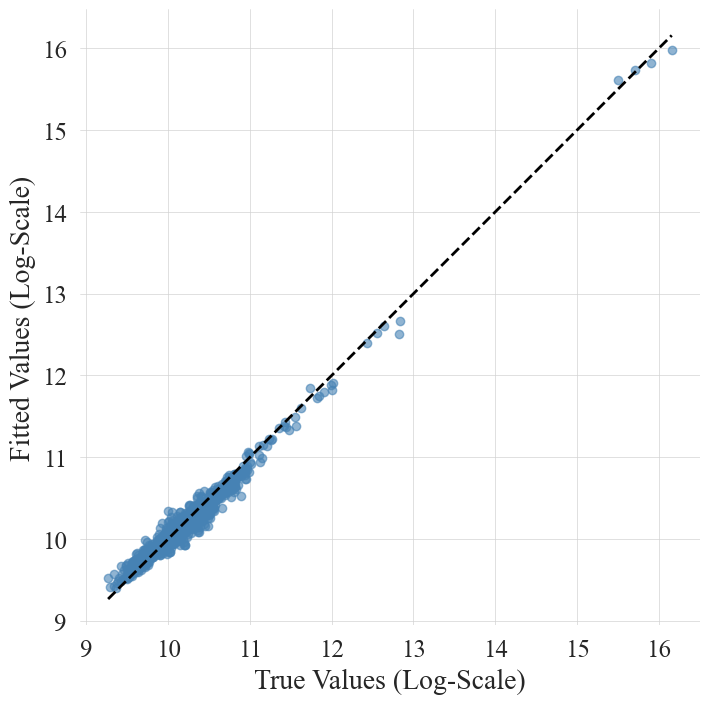

In [113]:
# Plot true vs fitted
plot_true_vs_fitted(y_test1, y_hat1, filename="./figures/ymodel_scatter.png")

                      Importance
Jobs_Density_16_64  2.603671e-01
Pop_Male_Prop       8.829168e-02
Pop_Aged_0_15_Prop  6.831994e-02
LACD_E09000001      6.243855e-02
Pop_Female_Prop     6.211697e-02
...                          ...
LACD_E08000021      1.717276e-06
LACD_E08000005      1.658409e-06
LACD_E08000016      1.631632e-06
LACD_E07000175      1.380546e-06
LACD_E06000047      9.729671e-07

[345 rows x 1 columns]


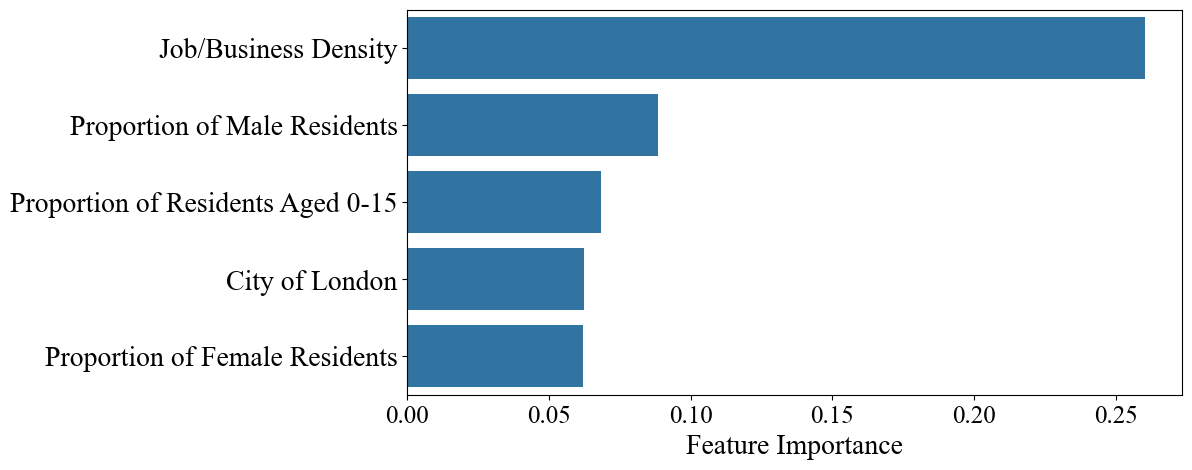

In [73]:
# Extract feature importance
feature_importances1 = random_search1.best_estimator_.feature_importances_
feature_importances_df1 = pd.DataFrame(feature_importances1,
                                      index=X1.columns,
                                      columns=['Importance'])
feature_importances_df1 = feature_importances_df1.sort_values(
    by='Importance',
    ascending=False)

# Display full feature importance output
print(feature_importances_df1)

# Set the font size for the entire plot
plt.rcParams.update({
    'axes.labelsize': 20,
    'xtick.labelsize': 18,
    'ytick.labelsize': 20,
})

# Custom variable names
custom_labels = {
    'Jobs_Density_16_64': 'Job/Business Density',
    'Pop_Male_Prop': 'Proportion of Male Residents',
    'Pop_Aged_0_15_Prop': 'Proportion of Residents Aged 0-15',
    'LACD_E09000001': 'City of London',
    'Pop_Female_Prop': 'Proportion of Female Residents'
}

# Extract the top 5 features
top_features1 = feature_importances_df1['Importance'][:5]
feature_names1 = feature_importances_df1.index[:5]

# Rename the features according to the custom labels
renamed_feature_names1 = [custom_labels.get(name, name) 
                          for name in feature_names1]

# Plotting
plt.figure(figsize=(10, 5))
sns.barplot(x=top_features1, y=renamed_feature_names1)

# Adding labels and title
plt.xlabel('Feature Importance')  # Name for the x-axis

# Save the plot
plt.savefig('./figures/ymodel_features.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()
